# Sensitivity of biofouling parameters - Plastic pollution from Croatian fishing vessels
In this example, we will use `plasticparcels` to run a basic simulation of microplastic pollution emitted from Croatian registered fishing vessels. We will use the [Open-sea fishing-related plastic emissions dataset](https://plastic.oceanparcels.org/en/latest/initialisationmaps.html#open-sea-fishing-related-plastic-emissions) to release virtual particles in ocean model grid cells, using the 3D velocity fields to advect the particles. We also include the effects of biofouling and Stokes drift on the particles. We will run two simulations, one with the default biofouling parameters, and another where we vary some of the biofouling parameters.

In [1]:
# Library imports
from datetime import datetime, timedelta

# Parcels and PlasticParcels imports
import plasticparcels as pp

# Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

## Load settings
We first load in the model settings, and define the simulation settings. For this simulation, we will release the particles at midnight on January 1st 2019. The particle trajectories will be 30 days long, saving the their position every 12 hours. We also set the advection timestep to 20 minutes.

We will also download the necessary release location files (if they are not already downloaded). In our case, as we expect our particles to remain in the Mediterranean Sea, we include `indices` in our ocean model to help speed up the file IO.

In [2]:
# Load the model settings
settings_file = 'docs/examples/example_Greece_coast_settings.json'
settings = pp.utils.load_settings(settings_file)

# Download the mask and release data
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')

# Set ocean model indices
settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400)}

In [3]:
# Create the simulation settings
settings['simulation'] = {
    'startdate': datetime.strptime('2019-01-01-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=30),              # Runtime of simulation
    'outputdt': timedelta(hours=12),            # Timestep of output
    'dt': timedelta(minutes=20),                # Timestep of advection
    }

# Overwrite some settings
settings['use_3D'] = True
settings['use_biofouling'] = True
settings['use_stokes'] = True
settings['use_wind'] = False

Next, we define our release settings and plastic particle type. In this example we will use the `fisheries` release type (see [here](https://plastic.oceanparcels.org/en/latest/initialisationmaps.html) for more detail), selecting only release locations related to Croatian fishing vessels. We will simulate the pathways of plastic particles that are 0.1mm in diameter. We will give the plastic particles a denisity of 1028 kg/m<sup>3</sup>.

In [4]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'fisheries',
    'country': 'Croatia',
}

In [5]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.0,   # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1028.,  # Plastic particle density (kg/m^3)
}

## Create a `FieldSet`, `ParticleSet` and `Kernel` list
Here we create the necessary `Parcels` objects to run our simulation. The `FieldSet` contains all the hydrodynamic, wind, and wave data required for our simulation. The `ParticleSet` is a set of particles initialised along the Greek coastline, and the `Kernel` list is a list of kernels that will be applied to these particles. A useful overview of these `Parcels` objects can be found [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_parcels_structure.html).

In [6]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

Define the runtime, the timestepping, and the output frequency of the simulation from the settings.

In [7]:
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

## Run the simulation
To run the simulation we create a `ParticleFile` that will store the trajectory information of all particles at the specified output timestep. We then `execute` the simulation with the specified runtime and timestepping.

In [8]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Croatia_fisheries.zarr', pset, settings=settings, outputdt=outputdt)

In [9]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_Croatia_fisheries.zarr.
100%|██████████| 2592000.0/2592000.0 [07:49<00:00, 5524.98it/s]


## Plot the trajectories
Finally, we produce a simple 'spaghetti' plot of the trajectories to visualise their pathways. To understand how to work with `PlasticParcels` output, please see the `Parcels` tutorial [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_output.html).

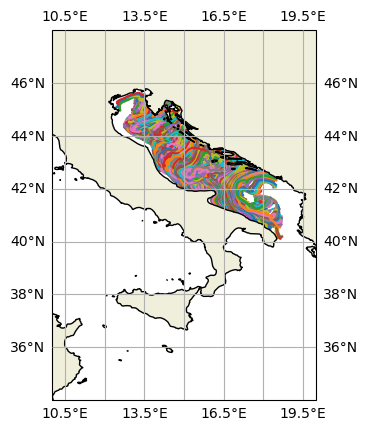

In [10]:
# Load the ParticleFile
ds = xr.open_zarr('example_Croatia_fisheries.zarr')

# Plot the trajectories
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
ax.set_extent([10, 20, 34, 48], crs=ccrs.PlateCarree())
plt.show()

## Varying the biofouling parameters
Now, we will run a simulation where we vary some of the parameters in the biofouling kernel. Let's first look at what parameter values we can play with.

In [11]:
settings['bgc']['constants']

{'biofilm_density': 1388.0,
 'algae_cell_volume': 2e-16,
 'K': 1.3805834190672156e-23,
 'R20': 1.1574074074074074e-06,
 'Q10': 2.13,
 'Gamma': 2.0,
 'carbon_molecular_weight': 12.0,
 'collision_probability': 1.0,
 'algae_mortality_rate': 1.0,
 'algae_respiration_f': 1.0}

Let's vary the collision probability, decrease the mortality rate, and increase the biofilm density. Of course, in a true sensitivity analysis one would consider the effects of one parameter at a time!

In [12]:
settings['bgc']['constants']['biofilm_density'] = 1400.0        # Biofilm density (kg/m^3)
settings['bgc']['constants']['collision_probability'] = 0.75    # Probability of collision with ambient algae
settings['bgc']['constants']['algae_mortality_rate'] = 0.80     # Mortality rate of biofilm

As we have updated the settings, we must reload the fieldset (and particleset and kernel list) to include these new settings.

In [13]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

Let's now run a simulation with these new parameters.

In [14]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Croatia_fisheries_sensitivity.zarr', pset, settings=settings, outputdt=outputdt)

In [15]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_Croatia_fisheries_sensitivity.zarr.
100%|██████████| 2592000.0/2592000.0 [19:57<00:00, 2163.97it/s] 


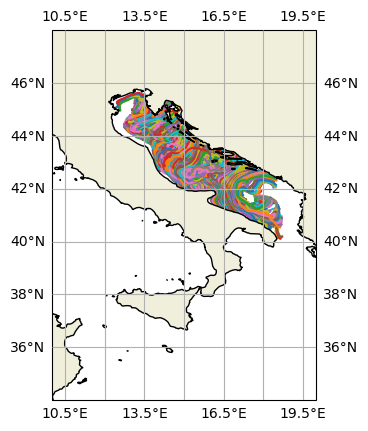

In [16]:
# Load the ParticleFile
ds = xr.open_zarr('example_Croatia_fisheries_sensitivity.zarr')

# Plot the trajectories
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
ax.set_extent([10, 20, 34, 48], crs=ccrs.PlateCarree())
plt.show()

Let's naively compare the two simulations.

In [17]:
ds_standard = xr.open_zarr('example_Croatia_fisheries.zarr')
ds_custom = xr.open_zarr('example_Croatia_fisheries_sensitivity.zarr')

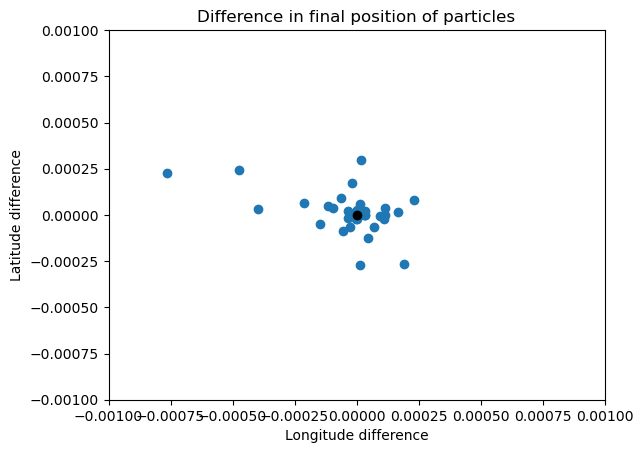

In [18]:
# Plot the difference in final position of the particles
plt.scatter(ds_standard['lon'].values.T[-1] - ds_custom['lon'].values.T[-1], ds_standard['lat'].values.T[-1] - ds_custom['lat'].values.T[-1])
plt.scatter([0],[0], c='k')
plt.ylabel('Latitude difference')
plt.xlabel('Longitude difference')
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])
plt.title("Difference in final position of particles")
plt.show()